# Featurize real data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM
import ssm
from ssm.util import find_permutation

from src.models.hmm import HistogramHMM
from src.data.synth_data import SynthBlockDataset
from src.features.fit_curves import get_sigmoid_feats
from src.features.losses import mse_loss

from src.features.fit_curves import epsilon_sigmoid
from src.visualization.plot_replications import plot_fitted_block, plot_sigmoids

from ssm.plots import gradient_cmap, white_to_color_cmap
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "light navy",
    
    "faded green",
    "dusty purple",
    "orange",
    "windows blue",
    "marigold",
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

/Users/johnzhou/miniconda3/envs/ssm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import sys 
sys.path.append("/Users/johnzhou/research/decision-making")

import numpy as np
from scipy.optimize import minimize
import seaborn as sns

from src.features.losses import mse_loss
from src.features.fit_curves import get_sigmoid_feats
from src.data.real_data import RealSessionDataset, convert_real_actions
from src.data.environments import DynamicForagingTask
from src.data.experiments import RealExperiment
from src.utils import blockify, build_config, normalize_choice_block_side, average_choice_blocks, truncate_blocks

In [3]:
directory = "/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging"
filenames = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        filenames.append(f)
    print(f)

/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR15_DynamicForaging_20221020_134822.mat
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR17_DynamicForaging_20221017_155902.mat
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR16_DynamicForaging_20221019_111458.mat
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR17_DynamicForaging_20221018_124021.mat
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR17_DynamicForaging_20221006_160204.mat
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR16_DynamicForaging_20221011_132928.mat
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR16_DynamicForaging_20221020_134759.mat
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221017_155907.mat
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR16_DynamicForaging_20221006_152352.mat
/Users/johnzhou/research/dec

In [4]:
choice_blocks = []
num_blocks = 0
fit_loss = mse_loss
block_bounds = []
total_blocks = 0

mouse_name = "MR18"

for idx, filename in enumerate(sorted(filenames)):
    if mouse_name not in filename:
        continue
#     if "1014" not in filename:
#         continue
    block_count = 0
    try:
        expt = RealExperiment(filename, task_type=DynamicForagingTask)
    except ValueError:
        print(f"Failed to load {filename}")
        continue
    
    blocks = expt.blocks
    num_blocks += len(blocks)
    actions = expt.action_history
    blocked_actions = blockify(expt.blocks, actions)
    normalized_actions = [normalize_choice_block_side(blocked_actions[block_idx], side=blocks[block_idx][0])
                          for block_idx in range(len(blocks))]
    truncated_actions = truncate_blocks(normalized_actions)
    
    for choice_block in truncated_actions:
        if len(choice_block) < 15:
            continue
        else:
            choice_blocks.append(choice_block)
            block_count += 1
            total_blocks += 1
#             print(choice_block)
    print(f"{filename} yields {block_count}")
    block_bounds.append(total_blocks)


/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221006_151941.mat yields 12
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221007_165441.mat yields 9
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221010_140054.mat yields 3
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221011_141239.mat yields 16
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221012_114333.mat yields 13
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221013_123144.mat yields 13
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221014_132026.mat yields 14
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221017_155907.mat yields 14
/Users/johnzhou/research/decision-making/data/raw/dynamic_

In [10]:
fname = "/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221006_151941.mat"

expt = RealExperiment(filename, task_type=DynamicForagingTask)

valid_idxs = np.argwhere(~np.isnan(expt.data.actions)).flatten()
converted_actions = []
invalid_idxs2 = []
for idx, act in enumerate(list(expt.data.actions)):
    if np.isnan(act):
        invalid_idxs2.append(idx)
        continue
    else:
        converted_actions.append(int(act - 1))
print(np.array_equal(np.array(convert_real_actions(expt.data.actions[valid_idxs])), np.array(converted_actions)))

blocks = expt.blocks
num_blocks += len(blocks)
actions = expt.action_history
blocked_actions = blockify(expt.blocks, actions)
normalized_actions = [normalize_choice_block_side(blocked_actions[block_idx], side=blocks[block_idx][0])
                      for block_idx in range(len(blocks))]
truncated_actions = truncate_blocks(normalized_actions)



True


In [11]:
print(block_bounds)

[12, 21, 24, 40, 53, 66, 80, 94, 108, 121, 136, 151]


In [12]:
sigmoids = []
sigmoid_params = get_sigmoid_feats(choice_blocks, fit_loss, plot=False)
sigmoids.append(sigmoid_params)

100%|████████████████████████████████████████| 151/151 [00:00<00:00, 805.90it/s]


In [22]:
expt_name = "generate_ssm_histogram"
repo_path = "/Users/johnzhou/research/decision-making"
expt_data = SynthBlockDataset(expt_name, repo_path)
boundary = list(expt_data.agent_labels == 1).index(True)

offset_bins = list(range(-1, 15))
mf_hist, mf_bins = np.histogramdd(expt_data.sigmoid_parameters[:boundary, :], bins=[100, 100, offset_bins])
mb_hist, mb_bins = np.histogramdd(expt_data.sigmoid_parameters[boundary:, :], bins=[100, 100, offset_bins])
emission_hists = [mf_hist / np.sum(mf_hist), mb_hist / np.sum(mb_hist)]
emission_bins = [mf_bins, mb_bins]

In [23]:
X = np.squeeze(np.array(sigmoids))
hist_model = HistogramHMM(2, 3, emission_hists, emission_bins, random_state=idx)
a = hist_model._compute_log_likelihood(X)
invalid_idxs = np.argwhere(np.all(a==np.array([np.NINF, np.NINF]), axis=1)).flatten()
print(invalid_idxs)

X = np.delete(X, invalid_idxs, axis=0)
time_bins = X.shape[0]
# np.save("sigs.npy", X)
print(a)

[]
[[-4.51514668        -inf]
 [-7.64589983        -inf]
 [-4.02273113        -inf]
 [-4.44067321        -inf]
 [-4.88461957        -inf]
 [-4.9038458         -inf]
 [-5.47744403        -inf]
 [-7.46288116        -inf]
 [-3.66438198 -4.63192492]
 [-4.57930753        -inf]
 [-3.95378294        -inf]
 [-3.99529592        -inf]
 [-4.74673375        -inf]
 [-2.95963181 -0.42489872]
 [-3.96268492 -2.68924807]
 [-4.34188327 -1.51512823]
 [-5.20228018        -inf]
 [-2.95963181 -0.42489872]
 [-2.95963181 -0.42489872]
 [-3.75007424 -4.28526297]
 [-4.74673375        -inf]
 [-6.06705053        -inf]
 [-4.15307598 -7.45593669]
 [-3.99529592        -inf]
 [-4.15307598 -7.45593669]
 [-3.99529592        -inf]
 [-4.51514668        -inf]
 [-6.09239047        -inf]
 [-4.34188327 -1.51512823]
 [-3.75007424 -4.28526297]
 [-4.34188327 -1.51512823]
 [-3.66438198 -4.63192492]
 [-2.95963181 -0.42489872]
 [-3.96268492 -2.68924807]
 [-7.28172172        -inf]
 [-4.34188327 -1.51512823]
 [-2.95963181 -0.42489872

/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


In [24]:
print(X.shape)
models = []
scores = []
transmat = np.array([[0.5, 0.5],
                    [0.5, 0.5]])
for idx in range(10):
    # define our hidden Markov model
    model = HistogramHMM(2, 3, emission_hists, emission_bins, random_state=idx)
#                          , init_params="s", params="s")
#     model.transmat_ = transmat
    model.fit(X)
    models.append(model)
    scores.append(model.score(X))
    print(f'Converged: {model.monitor_.converged}'
          f'\tScore: {scores[-1]}')

hist_model = models[np.argmax(scores)]
n_states = hist_model.n_components
print(f'The best model had a score of {max(scores)} and {n_states} '
      'states')
hist_predicted_states = hist_model.predict(X)
print(hist_predicted_states)

(151, 3)
Converged: True	Score: -450.584515723189


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -450.58461000073765
Converged: True	Score: -450.5846841272415


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -450.5846388126923
Converged: True	Score: -450.584507102874


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -450.5843885372469
Converged: True	Score: -450.58423773910806


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -450.5846269691353
Converged: True	Score: -450.58419151668517
Converged: True	Score: -450.58424999051635
The best model had a score of -450.58419151668517 and 2 states
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1
 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1
 1 1 1]


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


In [25]:
scores = []
models = []

for idx in range(10):
    # define our hidden Markov model
    model = GaussianHMM(n_components=2,
                            covariance_type='full',
                            random_state=idx)
    model.fit(X)  # 50/50 train/validate
    models.append(model)
    scores.append(model.score(X))
    print(f'Converged: {model.monitor_.converged}'
          f'\tScore: {scores[-1]}')

gaussian_model = models[np.argmax(scores)]
n_states = gaussian_model.n_components
print(f'The best model had a score of {max(scores)} and {n_states} '
      'states')
predicted_states = gaussian_model.predict(X)
print(predicted_states)

Converged: True	Score: -99.36179753704246
Converged: True	Score: -96.93603775076798
Converged: True	Score: 388.1851360669374
Converged: True	Score: -93.79904910410242
Converged: True	Score: -94.10799318755471
Converged: True	Score: 393.64118647627396
Converged: True	Score: 397.88633323281687
Converged: True	Score: -113.05518023132986
Converged: True	Score: -96.91239737256714
Converged: True	Score: -93.7782739839921
The best model had a score of 397.88633323281687 and 2 states
[0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


In [26]:
num_states = 2
obs_dim = 3
obs_model = "gaussian"
N_iters = 1000
fit_method = "em"

hmm = ssm.HMM(num_states, obs_dim, observations=obs_model) 
hmm_lls = hmm.fit(X, method=fit_method, num_em_iters=N_iters, init_method="kmeans")

hmm_z = hmm.most_likely_states(X)

LP: -73.9: 100%|█████████████████████████████| 100/100 [00:00<00:00, 275.12it/s]


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


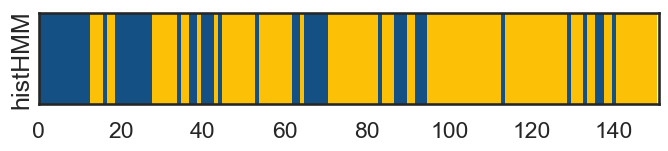

In [27]:
# predicted_states = 1 - predicted_states
# plt.figure(figsize=(8, 4))
# plt.subplot(311)
# plt.imshow(predicted_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
# # plt.vlines(block_bounds, color="white", ymin=0, ymax=0.25)
# # plt.ylim(0, 0.5)
# plt.xlim(0, time_bins)
# plt.ylabel("HMMLearn")
# plt.yticks([])

# hmm_z = 1 - hmm_z
# plt.figure(figsize=(8, 4))
# plt.subplot(312)
# plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
# # plt.vlines(block_bounds, color="white", ymin=0, ymax=0.25)
# # plt.ylim(0, 0.5)
# plt.xlim(0, time_bins)
# plt.ylabel("GaussianHMM")
# plt.yticks([])

hist_plot = np.array([-1 if state == 0 else state for state in hist_predicted_states])
print(type(hist_plot))
print(type(hist_predicted_states))

plt.figure(figsize=(8, 4))
plt.subplot(311)
plt.imshow(hist_predicted_states[None,:], aspect="auto", cmap=cmap)
# plt.vlines(block_bounds, color="white", ymin=0, ymax=0.25)
# plt.ylim(0, 0.5)
plt.xlim(0, time_bins)

plt.ylabel("histHMM")
plt.yticks([])

plt.savefig(f'/Users/johnzhou/Desktop/{mouse_name}_predicted_states.pdf', format='pdf')

12
[12, 21, 24, 40, 53, 66, 80, 94, 108, 121, 136, 151]
[0, 12, 21, 24, 40, 53, 66, 80, 94, 108, 121, 136, 151]
[(0, 12), (12, 21), (21, 24), (24, 40), (40, 53), (53, 66), (66, 80), (80, 94), (94, 108), (108, 121), (121, 136), (136, 151)]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1
 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1
 1 1 1]
[0.0, 0.5555555555555556, 0.0, 0.5625, 0.6923076923076923, 0.6923076923076923, 0.6428571428571429, 0.5714285714285714, 0.9285714285714286, 0.9230769230769231, 0.8666666666666667, 0.8]


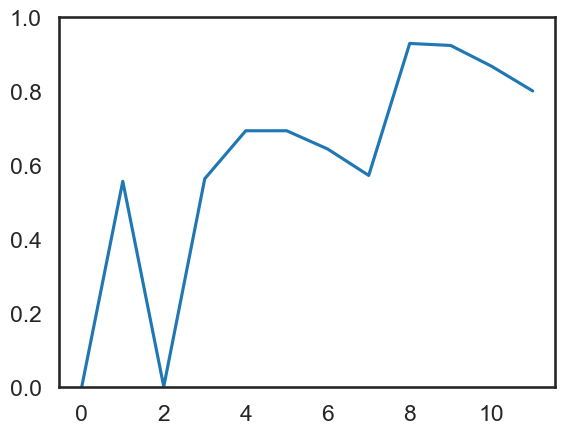

In [28]:
print(len(block_bounds))
print(block_bounds)

new_bounds = [0] + block_bounds
new_bounds = list(np.unique(np.array(new_bounds)))
print(list(np.unique(np.array(new_bounds))))
indices = [(new_bounds[i], new_bounds[i+1]) for i in range(len(new_bounds) - 1)]
print(indices)

print(hist_predicted_states)
percent_mb = [np.mean(hist_predicted_states[start:end]) for start, end in indices]
print(percent_mb)
plt.figure()
plt.ylim([0, 1])
plt.plot(percent_mb)

plt.savefig(f'/Users/johnzhou/Desktop/{mouse_name}_mb_percentage.eps', format='eps')

In [29]:
def visualize_sigmoids(sigmoid_params, idxs):
    params_list = sigmoid_params[idxs.flatten(), ...]
    plot_sigmoids(epsilon_sigmoid, params_list)
    
def visualize_regimes(state_preds, sigmoid_params):
    plt.figure()
    plt.subplot(211)
    idxs_0 = np.argwhere(state_preds == 0)
    visualize_sigmoids(sigmoid_params, idxs_0)
    plt.figure()
    plt.subplot(212)
    idxs_1 = np.argwhere(state_preds == 1)
    visualize_sigmoids(sigmoid_params, idxs_1)

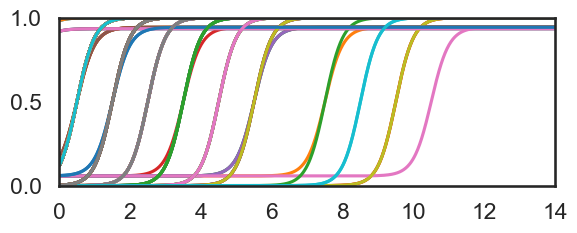

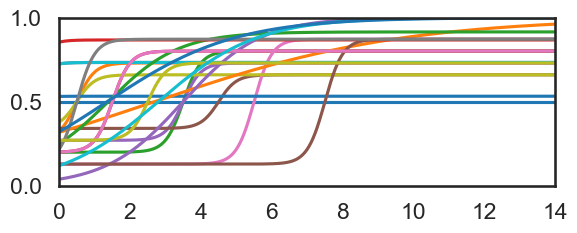

In [30]:
visualize_regimes(predicted_states, np.squeeze(X))

In [ ]:
visualize_regimes(hmm_z, np.squeeze(X))

In [ ]:
visualize_regimes(hist_predicted_states, np.squeeze(X))
print(hist_model.transmat_)
print(np.sum(hist_predicted_states)/hist_predicted_states.size)

In [ ]:
true_transition_mat = transmat
learned_transition_mat = hist_model.transmat_
print(true_transition_mat)
print(learned_transition_mat)

fig = plt.figure(figsize=(8, 4))
plt.subplot(121)
im = plt.imshow(true_transition_mat, cmap='gray')
plt.title("True Transition Matrix")

plt.subplot(122)
im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()